# Multi-Sensor Lake Ice Phenology Detection
## Alaska Thermokarst Lakes - Sentinel-1 + Sentinel-2 + ERA5 Approach

**Goal:** Detect ice-on and ice-off dates for ~550 Alaska lakes using multi-sensor fusion

**Approach:**
1. Use Sentinel-2 NDSI as high-confidence ground truth (when clouds permit)
2. Train Random Forest on S1 features using S2 labels
3. Use trained model to interpolate between S2 observations
4. Apply ERA5 temperature constraints for validation
5. Detect ice-on/ice-off transitions with confidence scoring

**Based on:** Tom et al. (2020) - using optical data to train SAR interpretation

---
## Part 1: Setup and Configuration

In [1]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Initialize Earth Engine
ee.Initialize()

print("Imports successful!")
print(f"Earth Engine initialized: {ee.String('GEE Initialized').getInfo()}")

/opt/conda/envs/gee/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.


Imports successful!
Earth Engine initialized: GEE Initialized


In [2]:
# Configuration
YEAR = 2023
BUCKET = 'wustl-eeps-geospatial'
LAKE_ASSET = 'projects/eeps-geospatial/assets/alaska_lakes' 
LAKE_ID_FIELD = 'id'
SCALE = 10  # Sentinel-1 resolution

# Alaska Albers projection
proj_ak = ee.Projection('EPSG:3338')

print(f"Configuration set for year {YEAR}")
print(f"Will export to gs://{BUCKET}/thermokarst_lakes/")

Configuration set for year 2023
Will export to gs://wustl-eeps-geospatial/thermokarst_lakes/


---
## Part 2: Load and Prepare Lake Geometries

In [34]:
# Load lakes
lakes = ee.FeatureCollection(LAKE_ASSET)
print(f"Loaded {lakes.size().getInfo()} lakes")

# Add geometry metrics
def add_geom_metrics(feat):
    geom = feat.geometry().transform(proj_ak, 1)
    area = geom.area(1)
    perim = geom.perimeter(1)
    centroid = geom.centroid(1)
    coords = centroid.coordinates()
    circularity = ee.Number(4).multiply(ee.Number(np.pi)).multiply(area).divide(perim.pow(2))
    
    return feat.set({
        'lake_area_m2': area,
        'lake_perim_m': perim,
        'circularity': circularity,
        'centroid_lon': coords.get(0),
        'centroid_lat': coords.get(1)
    })

lakes_with_geom = lakes.map(add_geom_metrics)

# Create buffered lake interiors
def buffer_interior(feat):
    geom = feat.geometry()
    area = geom.area()
    
    # Use fixed 10m negative buffer - 67% approach was too aggressive on small lakes
    buffered = geom.buffer(-10)
    # For very small lakes, use original geometry
    buffered = ee.Algorithms.If(
        area.lt(10000),  # If lake < 10,000 m² (0.01 km²)
        geom,            # Use full lake
        buffered         # Otherwise use 10m buffer
    )   
    return feat.setGeometry(ee.Geometry(buffered))

lakes_buf = lakes_with_geom.map(buffer_interior)

# Create landscape rings (100m around lakes)
def create_landscape_ring(feat):
    lake_geom = feat.geometry()
    outer_buffer = lake_geom.buffer(100)
    ring = outer_buffer.difference(lake_geom)
    return feat.setGeometry(ring)

landscape_rings = lakes_with_geom.map(create_landscape_ring)

print("Lake geometries prepared:")
print("  - Original lakes")
print("  - Buffered interiors (10m)")
print("  - Landscape rings (100m)")

Loaded 541 lakes
Lake geometries prepared:
  - Original lakes
  - Buffered interiors (10m)
  - Landscape rings (100m)


---
## Part 3: Define Data Collection Functions

In [4]:
# Sentinel-1 collection
def get_s1_collection(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    coll = (ee.ImageCollection('COPERNICUS/S1_GRD')
            .filterBounds(lakes.geometry())
            .filterDate(start, end)
            .filter(ee.Filter.eq('instrumentMode', 'IW'))
            .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
            .filter(ee.Filter.eq('resolution_meters', 10)))
    
    def prep_s1(img):
        angle = img.select('angle')
        angle_mask = angle.gt(25).And(angle.lt(50))
        
        # Process VV
        vv_lin = ee.Image(10.0).pow(img.select('VV').divide(10.0)).updateMask(angle_mask)
        vv_lin_f = vv_lin.focal_mean(1)
        vv_db = vv_lin_f.log10().multiply(10).rename('VV_db')
        
        # Process VH
        vh_lin = ee.Image(10.0).pow(img.select('VH').divide(10.0)).updateMask(angle_mask)
        vh_lin_f = vh_lin.focal_mean(1)
        vh_db = vh_lin_f.log10().multiply(10).rename('VH_db')
        
        return vv_db.addBands(vh_db).copyProperties(img, img.propertyNames())
    
    return coll.map(prep_s1)

# Sentinel-2 collection with pixel-level cloud masking
def get_s2_collection(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    coll = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterBounds(lakes.geometry())
            .filterDate(start, end)
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)))  # Relaxed from 30% to 50%
    
    def compute_ndsi(img):
        # Use QA60 to mask clouds at pixel level
        qa = img.select('QA60')
        cloud_bit_mask = 1 << 10
        cirrus_bit_mask = 1 << 11
        
        # Mask clouds and cirrus
        mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
               qa.bitwiseAnd(cirrus_bit_mask).eq(0))
        
        # NDSI = (Green - SWIR1) / (Green + SWIR1)
        ndsi = img.normalizedDifference(['B3', 'B11']).rename('ndsi').updateMask(mask)
        # Ice mask: NDSI > 0.4
        ice_mask = ndsi.gt(0.4).rename('ice')
        
        return img.addBands(ndsi).addBands(ice_mask)
    
    return coll.map(compute_ndsi)

# ERA5 temperature collection
def get_era5_collection(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    # Get daily mean temperature
    era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate(start, end).select('temperature_2m')
    
    # Convert to daily means
    days = ee.List.sequence(0, 364)  # 365 days
    
    def daily_mean(day):
        date = start.advance(day, 'day')
        daily = era5.filterDate(date, date.advance(1, 'day')).mean()
        # Convert Kelvin to Celsius
        temp_c = daily.subtract(273.15).rename('temp_c')
        return temp_c.set('system:time_start', date.millis())
    
    return ee.ImageCollection.fromImages(days.map(daily_mean))

print("Data collection functions defined")

Data collection functions defined


---
## Part 4: Export Multi-Sensor Data

This will export three separate CSVs:
1. Sentinel-1 time series (VV, VH, RGB features)
2. Sentinel-2 time series (NDSI, ice fraction)
3. ERA5 daily temperature

We'll merge them later in Python.

In [20]:
# Load collections
s1 = get_s1_collection(YEAR)
s2 = get_s2_collection(YEAR)
era5 = get_era5_collection(YEAR)

print(f"S1 images: {s1.size().getInfo()}")
print(f"S2 images: {s2.size().getInfo()}")
print(f"ERA5 daily images: {era5.size().getInfo()}")

S1 images: 28
S2 images: 475
ERA5 daily images: 365


### Export 1: Sentinel-1 Data

In [18]:
def s1_to_features(img):
    vv_img = img.select('VV_db')
    vh_img = img.select('VH_db')
    
    # RGB bands - FIXED adaptive scaling
    r_band = vv_img.unitScale(-20, -5).multiply(255).byte().rename('R')
    g_band = vh_img.unitScale(-28, -12).multiply(255).byte().rename('G')
    b_band = vv_img.subtract(vh_img).unitScale(8, 18).multiply(255).byte().rename('B')
    
    rgb_img = ee.Image.cat([r_band, g_band, b_band])
    date_str = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    
    # Reducers
    vv_reducer = ee.Reducer.mean().combine(ee.Reducer.count(), sharedInputs=True)
    vh_reducer = ee.Reducer.mean()
    rgb_reducer = ee.Reducer.mean()
    
    # Reduce over lake interiors
    vv_stats = vv_img.reduceRegions(
        collection=lakes_buf,
        reducer=vv_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    vh_stats = vh_img.reduceRegions(
        collection=lakes_buf,
        reducer=vh_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    rgb_stats = rgb_img.reduceRegions(
        collection=lakes_buf,
        reducer=rgb_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    # Landscape context
    land_stats = rgb_img.reduceRegions(
        collection=landscape_rings,
        reducer=rgb_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    def add_metadata(f):
        lake_id_prop = f.get(LAKE_ID_FIELD)
        
        # Get stats for this lake
        vh_feature = vh_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        rgb_feature = rgb_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        land_feature = land_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        
        # Get geometry metrics from original
        orig = lakes_with_geom.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        
        # FIXED: Handle null VH values safely
        vv_val = ee.Number(f.get('mean'))
        vh_val = ee.Number(vh_feature.get('mean'))
        
        # Only compute ratio if both values exist
        vv_vh_ratio = ee.Algorithms.If(
            vh_feature.get('mean'),  # Check if VH exists
            vv_val.subtract(vh_val),  # Compute if exists
            ee.Number(-999)  # Null flag if missing
        )
        
        return (f.set('date', date_str)
                .set('sensor', 'S1')
                .set('vv_db', vv_val)
                .set('vh_db', vh_val)
                .set('vv_vh_ratio', vv_vh_ratio)
                .set('lake_R', rgb_feature.get('R'))
                .set('lake_G', rgb_feature.get('G'))
                .set('lake_B', rgb_feature.get('B'))
                .set('land_R', land_feature.get('R'))
                .set('land_G', land_feature.get('G'))
                .set('land_B', land_feature.get('B'))
                .set('lake_area_m2', orig.get('lake_area_m2'))
                .set('centroid_lon', orig.get('centroid_lon'))
                .set('centroid_lat', orig.get('centroid_lat'))
                .set('lake_id', ee.Number(lake_id_prop).toInt()))
    
    return vv_stats.map(add_metadata)

# Map over S1 images
s1_features = s1.map(s1_to_features).flatten()

# Export
s1_cols = [
    'lake_id', 'date', 'sensor',
    'vv_db', 'vh_db', 'vv_vh_ratio',
    'lake_R', 'lake_G', 'lake_B',
    'land_R', 'land_G', 'land_B',
    'lake_area_m2', 'centroid_lon', 'centroid_lat'
]

task_s1 = ee.batch.Export.table.toCloudStorage(
    collection=s1_features.select(s1_cols),
    description=f'Alaska_Lakes_S1_{YEAR}',
    bucket=BUCKET,
    fileNamePrefix=f'thermokarst_lakes/Alaska_Lakes_S1_{YEAR}',
    fileFormat='CSV',
    selectors=s1_cols
)

task_s1.start()
print(f"Started S1 export: {task_s1.id}")

Started S1 export: QPCJFGX3PB67S25CGEHKTK3J


### Export 2: Sentinel-2 Data

In [21]:
def s2_to_features(img):
    """
    Only export S2 data for lakes that this image actually covers
    """
    ice_img = img.select('ice')
    ndsi_img = img.select('ndsi')
    date_str = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    
    # KEY FIX: Only process lakes that intersect this image's footprint
    img_bounds = img.geometry()
    lakes_in_image = lakes_buf.filterBounds(img_bounds)
    
    # Reduce over lake interiors (only those in this image)
    ice_stats = ice_img.reduceRegions(
        collection=lakes_in_image,  # Only lakes covered by this image
        reducer=ee.Reducer.mean(),
        scale=20,  # S2 SWIR resolution
        tileScale=2
    )
    
    ndsi_stats = ndsi_img.reduceRegions(
        collection=lakes_in_image,  # Only lakes covered by this image
        reducer=ee.Reducer.mean(),
        scale=20,
        tileScale=2
    )
    
    def add_metadata(f):
        lake_id_prop = f.get(LAKE_ID_FIELD)
        ndsi_feature = ndsi_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        orig = lakes_with_geom.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        
        return (f.set('date', date_str)
                .set('sensor', 'S2')
                .set('ice_fraction', f.get('mean'))  # Fraction of pixels with ice
                .set('ndsi_mean', ndsi_feature.get('mean'))
                .set('lake_area_m2', orig.get('lake_area_m2'))
                .set('centroid_lon', orig.get('centroid_lon'))
                .set('centroid_lat', orig.get('centroid_lat'))
                .set('lake_id', ee.Number(lake_id_prop).toInt()))
    
    return ice_stats.map(add_metadata)

# Map over S2 images
s2_features = s2.map(s2_to_features).flatten()

# Export
s2_cols = [
    'lake_id', 'date', 'sensor',
    'ice_fraction', 'ndsi_mean',
    'lake_area_m2', 'centroid_lon', 'centroid_lat'
]

task_s2 = ee.batch.Export.table.toCloudStorage(
    collection=s2_features.select(s2_cols),
    description=f'Alaska_Lakes_S2_{YEAR}',
    bucket=BUCKET,
    fileNamePrefix=f'thermokarst_lakes/Alaska_Lakes_S2_{YEAR}',
    fileFormat='CSV',
    selectors=s2_cols
)

task_s2.start()
print(f"Started S2 export: {task_s2.id}")

Started S2 export: UJNBV53OYRYIVD4PWEYO4W26


### Export 3: ERA5 Temperature Data

In [11]:
# Get ERA5 as daily image collection
def get_era5_daily_grid(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate(start, end).select('temperature_2m')
    
    # Create daily means
    days = ee.List.sequence(0, 364)
    
    def daily_mean(day):
        date = start.advance(day, 'day')
        daily = era5.filterDate(date, date.advance(1, 'day')).mean()
        temp_c = daily.subtract(273.15).rename('temp_c')
        return temp_c.set('system:time_start', date.millis()).set('date', date.format('YYYY-MM-dd'))
    
    return ee.ImageCollection.fromImages(days.map(daily_mean))

era5_daily = get_era5_daily_grid(YEAR)

# Create point features at lake centroids
lake_points = lakes_with_geom.map(
    lambda f: ee.Feature(
        f.geometry().centroid(),
        {
            'lake_id': f.get(LAKE_ID_FIELD),
            'centroid_lon': f.get('centroid_lon'),
            'centroid_lat': f.get('centroid_lat')
        }
    )
)

print(f"Created {lake_points.size().getInfo()} lake centroid points")

# Sample temperature at each lake centroid for each day
def sample_at_lakes(img):
    date_str = img.get('date')
    
    # Sample at points (much faster than reduceRegions)
    samples = img.select('temp_c').sampleRegions(
        collection=lake_points,
        scale=11000,
        geometries=False
    )
    
    # Add date to each sample
    def add_date(f):
        return f.set('date', date_str).set('sensor', 'ERA5')
    
    return samples.map(add_date)

print("Sampling ERA5 at lake centroids...")
era5_features = era5_daily.map(sample_at_lakes).flatten()

# Export
era5_cols = ['lake_id', 'date', 'sensor', 'temp_c', 'centroid_lon', 'centroid_lat']

task_era5 = ee.batch.Export.table.toCloudStorage(
    collection=era5_features.select(era5_cols),
    description=f'Alaska_Lakes_ERA5_{YEAR}',
    bucket=BUCKET,
    fileNamePrefix=f'thermokarst_lakes/Alaska_Lakes_ERA5_{YEAR}',
    fileFormat='CSV',
    selectors=era5_cols
)

task_era5.start()
print(f"Started ERA5 export: {task_era5.id}")

httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.


Created 541 lake centroid points
Sampling ERA5 at lake centroids...
Started ERA5 export: C6WB4F4FMQGSDGF6B25EHQOJ


In [9]:
print("\n" + "="*60)
print("ALL EXPORTS STARTED")
print("="*60)
print(f"S1 task:   {task_s1.id}")
print(f"S2 task:   {task_s2.id}")
print(f"ERA5 task: {task_era5.id}")
print("\nEstimated completion time:")
print("  - S1:   60-90 minutes")
print("  - S2:   30-60 minutes")
print("  - ERA5: 90-120 minutes")
print("\nCheck status at: https://code.earthengine.google.com/tasks")
print("\nOnce complete, download CSVs from GCS bucket and continue to Part 5")


ALL EXPORTS STARTED
S1 task:   OAWAKGBTBPMXTA7WRMA4UHSJ
S2 task:   D6LSA5YNA3GPMETGI5XDXQP5
ERA5 task: X2NXEUY2ORZLPENWUADWBHOJ

Estimated completion time:
  - S1:   60-90 minutes
  - S2:   30-60 minutes
  - ERA5: 90-120 minutes

Check status at: https://code.earthengine.google.com/tasks

Once complete, download CSVs from your GCS bucket and continue to Part 5


---
## Part 5: Load and Merge Multi-Sensor Data

**Run this section after exports complete and CSVs are downloaded**

In [5]:
# Load the three CSVs
df_s1 = pd.read_csv(f'gs://{BUCKET}/thermokarst_lakes/Alaska_Lakes_S1_2023.csv')
df_s2 = pd.read_csv(f'gs://{BUCKET}/thermokarst_lakes/Alaska_Lakes_S2_2023.csv')
df_era5 = pd.read_csv(f'gs://{BUCKET}/thermokarst_lakes/Alaska_Lakes_ERA5_2023.csv')

# Convert dates
df_s1['date'] = pd.to_datetime(df_s1['date'])
df_s2['date'] = pd.to_datetime(df_s2['date'])
df_era5['date'] = pd.to_datetime(df_era5['date'])

print("Data loaded:")
print(f"  S1:   {len(df_s1):,} observations across {df_s1['lake_id'].nunique()} lakes")
print(f"  S2:   {len(df_s2):,} observations across {df_s2['lake_id'].nunique()} lakes")
print(f"  ERA5: {len(df_era5):,} observations across {df_era5['lake_id'].nunique()} lakes")

# Merge S1 + temperature (every S1 obs gets a temp)
df_s1 = df_s1.merge(df_era5[['lake_id', 'date', 'temp_c']], on=['lake_id', 'date'], how='left')

print(f"\nMerged S1 + temperature: {len(df_s1):,} observations")
print(f"Temperature coverage: {df_s1['temp_c'].notna().sum() / len(df_s1) * 100:.1f}%")

Data loaded:
  S1:   15,148 observations across 541 lakes
  S2:   64,499 observations across 541 lakes
  ERA5: 191,625 observations across 525 lakes

Merged S1 + temperature: 15,148 observations
Temperature coverage: 97.0%


In [8]:
# Deduplicate: keep only one S2 observation per lake per date
print(f"Before deduplication: {len(df_s2):,} rows")

# For duplicates, keep the one with highest ice_fraction confidence (furthest from 0.5)
df_s2['confidence'] = (df_s2['ice_fraction'] - 0.5).abs()
df_s2 = df_s2.sort_values('confidence', ascending=False).drop_duplicates(
    subset=['lake_id', 'date'], 
    keep='first'
)
df_s2 = df_s2.drop(columns='confidence')

print(f"After deduplication:  {len(df_s2):,} rows")
print(f"Removed {64499 - len(df_s2):,} duplicate observations")

# Recompute ice state
df_s2['s2_ice_state'] = 'PARTIAL'
df_s2.loc[df_s2['ice_fraction'] > 0.8, 's2_ice_state'] = 'ICE'
df_s2.loc[df_s2['ice_fraction'] < 0.2, 's2_ice_state'] = 'WATER'

Before deduplication: 64,499 rows
After deduplication:  37,368 rows
Removed 27,131 duplicate observations


In [9]:
# S2 coverage statistics
print("\nSentinel-2 Coverage Analysis:")
print("="*60)

s2_per_lake = df_s2.groupby('lake_id').size()
print(f"S2 observations per lake:")
print(f"  Mean:   {s2_per_lake.mean():.1f}")
print(f"  Median: {s2_per_lake.median():.0f}")
print(f"  Min:    {s2_per_lake.min():.0f}")
print(f"  Max:    {s2_per_lake.max():.0f}")

# Ice detection from S2
df_s2['s2_ice_state'] = 'PARTIAL'
df_s2.loc[df_s2['ice_fraction'] > 0.6, 's2_ice_state'] = 'ICE'    
df_s2.loc[df_s2['ice_fraction'] < 0.4, 's2_ice_state'] = 'WATER'  

print(f"\nS2 ice classification:")
print(df_s2['s2_ice_state'].value_counts())
print(f"\nClear detections (ICE or WATER): {((df_s2['s2_ice_state'] == 'ICE') | (df_s2['s2_ice_state'] == 'WATER')).sum() / len(df_s2) * 100:.1f}%")


Sentinel-2 Coverage Analysis:
S2 observations per lake:
  Mean:   69.1
  Median: 70
  Min:    48
  Max:    106

S2 ice classification:
s2_ice_state
ICE        24264
WATER      12242
PARTIAL      862
Name: count, dtype: int64

Clear detections (ICE or WATER): 97.7%


---
## Part 6: Train Random Forest Using S2 Labels

Find S1-S2 pairs (within ±3 days) and use S2 ice classification as training labels for S1 features

In [11]:
# Find S1-S2 pairs within ±3 days
def find_s2_label(row, s2_data, max_days=3):
    """
    For a given S1 observation, find the closest S2 observation within max_days
    """
    lake_s2 = s2_data[s2_data['lake_id'] == row['lake_id']].copy()
    if len(lake_s2) == 0:
        return None
    
    # Calculate time difference
    lake_s2['time_diff'] = abs((lake_s2['date'] - row['date']).dt.total_seconds() / 86400)
    
    # Find closest within max_days
    close = lake_s2[lake_s2['time_diff'] <= max_days]
    if len(close) == 0:
        return None
    
    closest = close.loc[close['time_diff'].idxmin()]
    return closest['s2_ice_state']

print("Finding S1-S2 pairs...")
df_s1['s2_label'] = df_s1.apply(lambda row: find_s2_label(row, df_s2), axis=1)

# Filter to rows with S2 labels and clear ice/water classification
df_training = df_s1[df_s1['s2_label'].isin(['ICE', 'WATER'])].copy()

print(f"\nTraining data created:")
print(f"  Total S1 observations: {len(df_s1):,}")
print(f"  With S2 labels: {len(df_training):,} ({len(df_training)/len(df_s1)*100:.1f}%)")
print(f"\nLabel distribution:")
print(df_training['s2_label'].value_counts())

Finding S1-S2 pairs...

Training data created:
  Total S1 observations: 15,148
  With S2 labels: 8,404 (55.5%)

Label distribution:
s2_label
ICE      5022
WATER    3382
Name: count, dtype: int64


In [12]:
# Add z-score features to training data
print("Computing lake-relative z-scores for training data...")

z_score_cols = ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 'land_R', 'land_G', 'land_B']

for col in z_score_cols:
    df_training[f'{col}_zscore'] = df_training.groupby('lake_id')[col].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )

# Prepare features and labels
feature_cols = ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 
                'land_R', 'land_G', 'land_B']

# Add z-score features
feature_cols_with_zscore = feature_cols + [f'{col}_zscore' for col in z_score_cols]

print(f"\nTotal features: {len(feature_cols_with_zscore)}")
print(f"  Original: {feature_cols}")
print(f"  Z-scores: {[f'{col}_zscore' for col in z_score_cols]}")

# Drop rows with missing features
df_training = df_training.dropna(subset=feature_cols_with_zscore)

X = df_training[feature_cols_with_zscore]  # ← Now uses both original + z-scores
y = df_training['s2_label']

# Convert labels to binary: ICE=1, WATER=0
y_binary = (y == 'ICE').astype(int)

print(f"\nTraining set: {len(X):,} samples with {len(feature_cols_with_zscore)} features")

Computing lake-relative z-scores for training data...

Total features: 18
  Original: ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 'land_R', 'land_G', 'land_B']
  Z-scores: ['vv_db_zscore', 'vh_db_zscore', 'vv_vh_ratio_zscore', 'lake_R_zscore', 'lake_G_zscore', 'lake_B_zscore', 'land_R_zscore', 'land_G_zscore', 'land_B_zscore']

Training set: 8,404 samples with 18 features


In [13]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

print(f"Train set: {len(X_train):,} samples")
print(f"Test set:  {len(X_test):,} samples")

# Train Random Forest
print("\nTraining Random Forest classifier...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Training complete!")

Train set: 5,882 samples
Test set:  2,522 samples

Training Random Forest classifier...
Training complete!



RANDOM FOREST PERFORMANCE

Accuracy: 0.904

Classification Report:
              precision    recall  f1-score   support

       WATER       0.82      0.97      0.89      1015
         ICE       0.98      0.86      0.91      1507

    accuracy                           0.90      2522
   macro avg       0.90      0.92      0.90      2522
weighted avg       0.92      0.90      0.91      2522



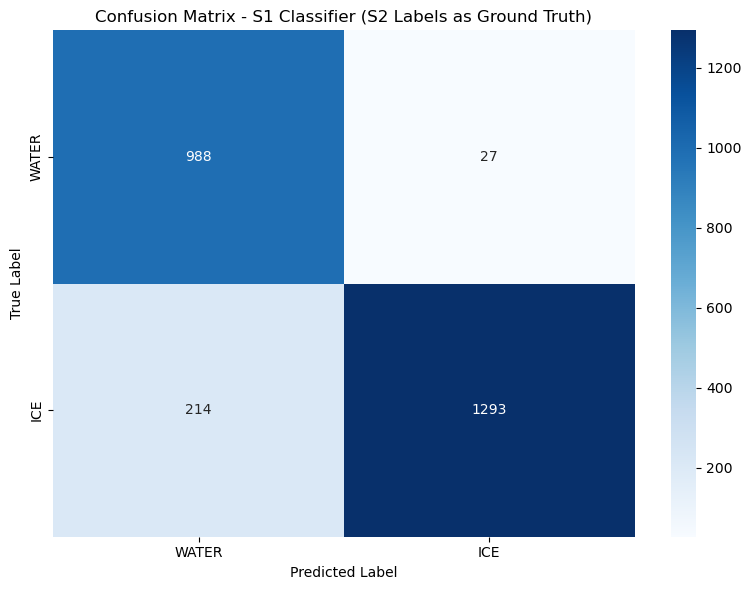


Saved: rf_confusion_matrix.png


In [14]:
# Evaluate on test set
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("RANDOM FOREST PERFORMANCE")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['WATER', 'ICE']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['WATER', 'ICE'], yticklabels=['WATER', 'ICE'])
plt.title('Confusion Matrix - S1 Classifier (S2 Labels as Ground Truth)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('rf_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: rf_confusion_matrix.png")


Feature Importance:
           feature  importance
     land_G_zscore    0.292093
     land_R_zscore    0.207548
            land_G    0.195686
            land_R    0.111129
     land_B_zscore    0.035233
            lake_R    0.022477
            land_B    0.021732
     lake_G_zscore    0.020558
             vv_db    0.019021
     lake_R_zscore    0.012530
      vh_db_zscore    0.011535
             vh_db    0.010775
            lake_G    0.009614
      vv_db_zscore    0.008013
            lake_B    0.006254
     lake_B_zscore    0.005851
       vv_vh_ratio    0.005354
vv_vh_ratio_zscore    0.004597


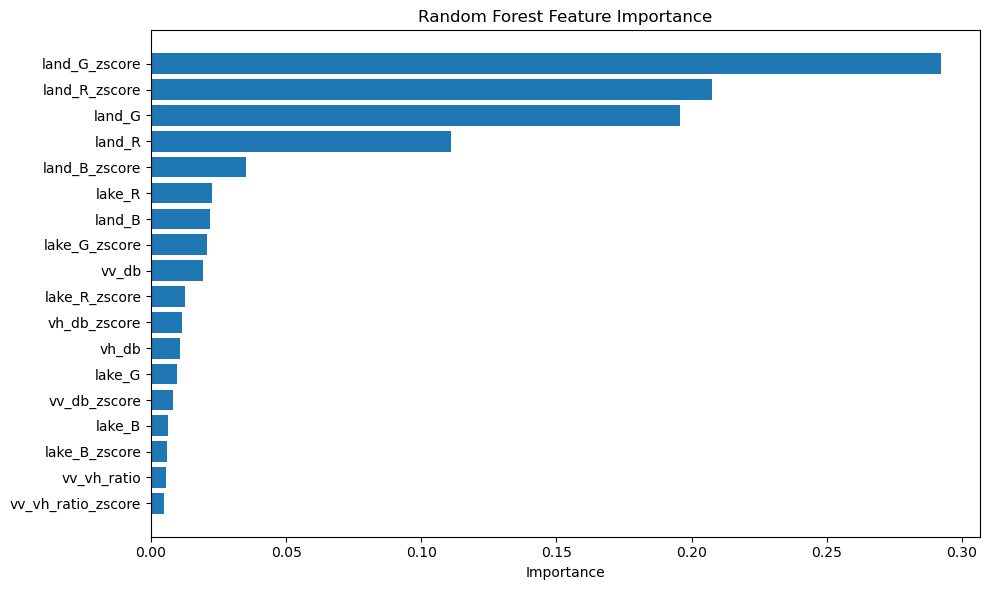


Saved: rf_feature_importance.png


In [16]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols_with_zscore,  # ← Changed from feature_cols
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: rf_feature_importance.png")

---
## Part 7: Apply Classifier to All S1 Data

In [18]:
# First, filter out invalid data
df_s1_clean = df_s1[(df_s1['vv_vh_ratio'] != -999)].copy()  # Remove null VH values
df_s1_clean = df_s1_clean.dropna(subset=feature_cols).copy()

print(f"Cleaned S1 data: {len(df_s1_clean):,} observations (removed {len(df_s1) - len(df_s1_clean):,} with missing data)")

# Add lake-relative z-score features
print("Computing lake-relative z-scores...")

z_score_cols = ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 'land_R', 'land_G', 'land_B']

for col in z_score_cols:
    df_s1_clean[f'{col}_zscore'] = df_s1_clean.groupby('lake_id')[col].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )

print(f"Added {len(z_score_cols)} z-score features")

# Update feature columns to include z-scores
feature_cols_with_zscore = feature_cols + [f'{col}_zscore' for col in z_score_cols]

print(f"\nTotal features for classifier: {len(feature_cols_with_zscore)}")
print(f"  Original features: {len(feature_cols)}")
print(f"  Z-score features: {len(z_score_cols)}")

Cleaned S1 data: 15,148 observations (removed 0 with missing data)
Computing lake-relative z-scores...
Added 9 z-score features

Total features for classifier: 18
  Original features: 9
  Z-score features: 9


In [20]:
# Apply Random Forest classifier to all S1 data
print("Applying Random Forest to all S1 observations...")

X_all = df_s1_clean[feature_cols_with_zscore]

# Predict
df_s1_clean['s1_ice_pred'] = rf.predict(X_all)
df_s1_clean['s1_ice_prob'] = rf.predict_proba(X_all)[:, 1]  # Probability of ICE class

print(f"\nPredictions complete!")
print(f"Total observations: {len(df_s1_clean):,}")
print(f"\nPredicted ice distribution:")
print(df_s1_clean['s1_ice_pred'].value_counts())
print(f"\nIce probability stats:")
print(df_s1_clean['s1_ice_prob'].describe())

Applying Random Forest to all S1 observations...

Predictions complete!
Total observations: 15,148

Predicted ice distribution:
s1_ice_pred
1    9169
0    5979
Name: count, dtype: int64

Ice probability stats:
count    15148.000000
mean         0.638565
std          0.392479
min          0.030370
25%          0.175240
50%          0.911424
75%          0.989487
max          0.999809
Name: s1_ice_prob, dtype: float64


---
## Part 8: Create Unified Multi-Sensor Time Series

Combine S2 (high confidence) + S1 (medium confidence) + temperature constraints

In [40]:
# Create unified dataset: ALL S1 dates + ALL S2 dates
print("Creating unified multi-sensor dataset...")

# Prepare S1 data
df_s1_for_unified = df_s1_clean[['lake_id', 'date', 'lake_area_m2', 'centroid_lon', 'centroid_lat',
                                   'temp_c', 's1_ice_pred', 's1_ice_prob']].copy()
df_s1_for_unified['has_s1'] = True

# Prepare S2 data (use deduplicated df_s2)
df_s2_for_unified = df_s2[['lake_id', 'date', 'ice_fraction']].copy()
df_s2_for_unified = df_s2_for_unified.rename(columns={'ice_fraction': 's2_ice_fraction'})
df_s2_for_unified['has_s2'] = True

# Merge on lake_id and date - keep ALL observations from both sensors
df_unified = pd.merge(
    df_s1_for_unified, 
    df_s2_for_unified, 
    on=['lake_id', 'date'], 
    how='outer'  # Keep all S1 dates AND all S2 dates
)

# Fill missing flags
df_unified['has_s1'] = df_unified['has_s1'].fillna(False)
df_unified['has_s2'] = df_unified['has_s2'].fillna(False)

# For S2-only dates, need to add temp and lake metadata
# Merge temperature for all dates
df_unified = df_unified.merge(
    df_era5[['lake_id', 'date', 'temp_c']], 
    on=['lake_id', 'date'], 
    how='left',
    suffixes=('', '_era5')
)
# Use ERA5 temp if S1 temp is missing
df_unified['temp_c'] = df_unified['temp_c'].fillna(df_unified.get('temp_c_era5', pd.Series()))
if 'temp_c_era5' in df_unified.columns:
    df_unified = df_unified.drop(columns=['temp_c_era5'])

# For S2-only dates, get lake metadata from first S1 observation of that lake
lake_metadata = df_s1_for_unified.groupby('lake_id')[['lake_area_m2', 'centroid_lon', 'centroid_lat']].first().reset_index()
df_unified = df_unified.merge(lake_metadata, on='lake_id', how='left', suffixes=('', '_meta'))
for col in ['lake_area_m2', 'centroid_lon', 'centroid_lat']:
    df_unified[col] = df_unified[col].fillna(df_unified.get(f'{col}_meta', pd.Series()))
    if f'{col}_meta' in df_unified.columns:
        df_unified = df_unified.drop(columns=[f'{col}_meta'])

print(f"Unified dataset created:")
print(f"  Total observations: {len(df_unified):,}")
print(f"  S1 only: {(df_unified['has_s1'] & ~df_unified['has_s2']).sum():,}")
print(f"  S2 only: {(df_unified['has_s2'] & ~df_unified['has_s1']).sum():,}")
print(f"  Both S1 and S2: {(df_unified['has_s1'] & df_unified['has_s2']).sum():,}")

Creating unified multi-sensor dataset...
Unified dataset created:
  Total observations: 50,834
  S1 only: 13,466
  S2 only: 35,686
  Both S1 and S2: 1,682


In [41]:
# Multi-sensor classification with confidence
def classify_multisensor(row):
    """
    Priority:
    1. S2 (if available): HIGH confidence
    2. Temperature constraints: MEDIUM confidence  
    3. S1 classifier: MEDIUM/LOW confidence
    
    Now we store BOTH S1 and S2 decisions separately when both exist
    """
    s2_decision = None
    s1_decision = None
    temp_decision = None
    
    # S2 classification (if available)
    if pd.notna(row['s2_ice_fraction']):
        if row['s2_ice_fraction'] > 0.8:
            s2_decision = (1, 'HIGH', 'S2')  # ICE
        elif row['s2_ice_fraction'] < 0.2:
            s2_decision = (0, 'HIGH', 'S2')  # WATER
        else:
            s2_decision = (0.5, 'MEDIUM', 'S2')  # PARTIAL
    
    # S1 classification (if available)
    if pd.notna(row.get('s1_ice_pred')):
        # Confidence based on prediction probability
        if row['s1_ice_prob'] > 0.7 or row['s1_ice_prob'] < 0.3:
            conf = 'MEDIUM'
        else:
            conf = 'LOW'
        s1_decision = (row['s1_ice_pred'], conf, 'S1')
    
    # Temperature constraints
    if pd.notna(row['temp_c']):
        if row['temp_c'] < -5:
            temp_decision = (1, 'MEDIUM', 'TEMP')  # Too cold for water
        elif row['temp_c'] > 10:
            temp_decision = (0, 'MEDIUM', 'TEMP')  # Too warm for ice
    
    # For final ice_binary decision, use priority: S2 > S1 > TEMP
    if s2_decision is not None:
        final_decision = s2_decision
    elif s1_decision is not None:
        final_decision = s1_decision
    elif temp_decision is not None:
        final_decision = temp_decision
    else:
        final_decision = (np.nan, 'NONE', 'NONE')
    
    # Store individual decisions for plotting
    return pd.Series({
        'ice_binary': final_decision[0],
        'confidence': final_decision[1],
        'source': final_decision[2],
        's1_ice_binary': s1_decision[0] if s1_decision else np.nan,
        's1_confidence': s1_decision[1] if s1_decision else 'NONE',
        's2_ice_binary': s2_decision[0] if s2_decision else np.nan,
        's2_confidence': s2_decision[1] if s2_decision else 'NONE',
    })

print("Classifying with multi-sensor fusion...")
classification_results = df_unified.apply(classify_multisensor, axis=1)
df_unified = pd.concat([df_unified, classification_results], axis=1)

print("\nMulti-sensor classification:")
print(df_unified['source'].value_counts())
print("\nConfidence distribution:")
print(df_unified['confidence'].value_counts())
print(f"\nObservations with both S1 and S2 decisions: {(df_unified['has_s1'] & df_unified['has_s2']).sum():,}")

Classifying with multi-sensor fusion...

Multi-sensor classification:
source
S2      37270
S1      13469
NONE       62
TEMP       33
Name: count, dtype: int64

Confidence distribution:
confidence
HIGH      34207
MEDIUM    15366
LOW        1199
NONE         62
Name: count, dtype: int64

Observations with both S1 and S2 decisions: 1,682


In [42]:
# Add temporal features
df_unified['month'] = df_unified['date'].dt.month
df_unified['doy'] = df_unified['date'].dt.dayofyear

# Sort by lake and date
df_unified = df_unified.sort_values(['lake_id', 'date']).reset_index(drop=True)

print(f"\nUnified dataset: {len(df_unified):,} observations")
print(f"Lakes: {df_unified['lake_id'].nunique()}")
print(f"Date range: {df_unified['date'].min()} to {df_unified['date'].max()}")


Unified dataset: 50,834 observations
Lakes: 541
Date range: 2023-01-10 00:00:00 to 2023-12-24 00:00:00


---
## Part 9: Temporal Smoothing and Ice Event Detection

In [43]:
# Temporal smoothing: rolling median per lake
def smooth_timeseries(g):
    g = g.sort_values('date').copy()
    
    # Rolling median (window=3)
    g['ice_smooth'] = (
        g['ice_binary']
        .rolling(window=3, center=True, min_periods=1)
        .median()
        .round()
    )
    
    return g

print("Applying temporal smoothing...")
df_unified = df_unified.groupby('lake_id', group_keys=False).apply(smooth_timeseries)

print("Smoothing complete")

Applying temporal smoothing...
Smoothing complete


In [44]:
# Detect ice-on and ice-off events
def detect_ice_events(g, min_run=2):
    """
    Detect ice-off (spring) and ice-on (fall) dates
    
    Ice-off: First sustained WATER (ice_smooth=0) after April 1 (DOY 91)
    Ice-on: First sustained ICE (ice_smooth=1) after September 1 (DOY 244)
    """
    g = g.sort_values('date').reset_index(drop=True)
    
    # Skip if no valid data
    if g['ice_smooth'].isna().all():
        return pd.Series({
            'ice_off_date': pd.NaT,
            'ice_on_date': pd.NaT,
            'ice_off_doy': np.nan,
            'ice_on_doy': np.nan,
            'ice_free_days': np.nan,
            'ice_off_confidence': 'NONE',
            'ice_on_confidence': 'NONE',
            'ice_off_source': None,
            'ice_on_source': None,
        })
    
    # Ice-off: first sustained water after April 1
    spring = g[g['doy'] >= 91].copy()
    ice_off_date = pd.NaT
    ice_off_conf = 'NONE'
    ice_off_source = None
    
    if not spring.empty:
        water_mask = spring['ice_smooth'] == 0
        count = 0
        for idx in spring.index:
            if water_mask.loc[idx]:
                count += 1
                if count >= min_run:
                    ice_off_idx = idx - count + 1
                    ice_off_date = g.loc[ice_off_idx, 'date']
                    ice_off_conf = g.loc[ice_off_idx, 'confidence']
                    ice_off_source = g.loc[ice_off_idx, 'source']
                    break
            else:
                count = 0
    
    # Ice-on: first sustained ice after September 1
    fall = g[g['doy'] >= 244].copy()
    ice_on_date = pd.NaT
    ice_on_conf = 'NONE'
    ice_on_source = None
    
    if not fall.empty:
        ice_mask = fall['ice_smooth'] == 1
        count = 0
        for idx in fall.index:
            if ice_mask.loc[idx]:
                count += 1
                if count >= min_run:
                    ice_on_idx = idx - count + 1
                    ice_on_date = g.loc[ice_on_idx, 'date']
                    ice_on_conf = g.loc[ice_on_idx, 'confidence']
                    ice_on_source = g.loc[ice_on_idx, 'source']
                    break
            else:
                count = 0
    
    # Compute ice-free days
    if pd.notna(ice_off_date) and pd.notna(ice_on_date):
        ice_free_days = (ice_on_date - ice_off_date).days
    else:
        ice_free_days = np.nan
    
    ice_off_doy = ice_off_date.dayofyear if pd.notna(ice_off_date) else np.nan
    ice_on_doy = ice_on_date.dayofyear if pd.notna(ice_on_date) else np.nan
    
    return pd.Series({
        'ice_off_date': ice_off_date,
        'ice_on_date': ice_on_date,
        'ice_off_doy': ice_off_doy,
        'ice_on_doy': ice_on_doy,
        'ice_free_days': ice_free_days,
        'ice_off_confidence': ice_off_conf,
        'ice_on_confidence': ice_on_conf,
        'ice_off_source': ice_off_source,
        'ice_on_source': ice_on_source,
    })

print("Detecting ice events...")
ice_events = df_unified.groupby('lake_id').apply(detect_ice_events).reset_index()

# Add lake metadata
lake_meta = df_unified.groupby('lake_id').agg({
    'centroid_lat': 'first',
    'centroid_lon': 'first',
    'lake_area_m2': 'first',
}).reset_index()

ice_events = ice_events.merge(lake_meta, on='lake_id')

print("Detection complete!")

Detecting ice events...
Detection complete!


---
## Part 10: Results and Summary Statistics

In [45]:
print("\n" + "="*70)
print("ICE EVENT DETECTION SUMMARY - MULTI-SENSOR APPROACH")
print("="*70)

print(f"\nTotal lakes: {len(ice_events)}")
print(f"Lakes with ice-off detected: {ice_events['ice_off_date'].notna().sum()} ({100*ice_events['ice_off_date'].notna().sum()/len(ice_events):.1f}%)")
print(f"Lakes with ice-on detected: {ice_events['ice_on_date'].notna().sum()} ({100*ice_events['ice_on_date'].notna().sum()/len(ice_events):.1f}%)")
print(f"Lakes with both events: {(ice_events['ice_off_date'].notna() & ice_events['ice_on_date'].notna()).sum()} ({100*(ice_events['ice_off_date'].notna() & ice_events['ice_on_date'].notna()).sum()/len(ice_events):.1f}%)")

print(f"\nIce-off confidence:")
print(ice_events['ice_off_confidence'].value_counts())
print(f"\nIce-off source:")
print(ice_events['ice_off_source'].value_counts())

print(f"\nIce-on confidence:")
print(ice_events['ice_on_confidence'].value_counts())
print(f"\nIce-on source:")
print(ice_events['ice_on_source'].value_counts())


ICE EVENT DETECTION SUMMARY - MULTI-SENSOR APPROACH

Total lakes: 541
Lakes with ice-off detected: 541 (100.0%)
Lakes with ice-on detected: 541 (100.0%)
Lakes with both events: 541 (100.0%)

Ice-off confidence:
ice_off_confidence
HIGH      331
MEDIUM    173
LOW        36
NONE        1
Name: count, dtype: int64

Ice-off source:
ice_off_source
S2      391
S1      149
NONE      1
Name: count, dtype: int64

Ice-on confidence:
ice_on_confidence
HIGH      503
MEDIUM     21
LOW        17
Name: count, dtype: int64

Ice-on source:
ice_on_source
S2    507
S1     34
Name: count, dtype: int64


In [46]:
# Phenology statistics
detected = ice_events[ice_events['ice_off_date'].notna() & ice_events['ice_on_date'].notna()].copy()

if len(detected) > 0:
    print(f"\n{'='*70}")
    print("PHENOLOGY STATISTICS (lakes with both events detected)")
    print(f"{'='*70}")
    print(f"\nN = {len(detected)} lakes")
    
    print(f"\nIce-off (day of year):")
    print(f"  Median: {detected['ice_off_doy'].median():.0f} ({pd.Timestamp('2024-01-01') + pd.Timedelta(days=detected['ice_off_doy'].median()):%b %d})")
    print(f"  Mean:   {detected['ice_off_doy'].mean():.0f}")
    print(f"  Std:    {detected['ice_off_doy'].std():.0f} days")
    print(f"  Range:  {detected['ice_off_doy'].min():.0f} - {detected['ice_off_doy'].max():.0f}")
    print(f"  IQR:    {detected['ice_off_doy'].quantile(0.25):.0f} - {detected['ice_off_doy'].quantile(0.75):.0f}")
    
    print(f"\nIce-on (day of year):")
    print(f"  Median: {detected['ice_on_doy'].median():.0f} ({pd.Timestamp('2024-01-01') + pd.Timedelta(days=detected['ice_on_doy'].median()):%b %d})")
    print(f"  Mean:   {detected['ice_on_doy'].mean():.0f}")
    print(f"  Std:    {detected['ice_on_doy'].std():.0f} days")
    print(f"  Range:  {detected['ice_on_doy'].min():.0f} - {detected['ice_on_doy'].max():.0f}")
    print(f"  IQR:    {detected['ice_on_doy'].quantile(0.25):.0f} - {detected['ice_on_doy'].quantile(0.75):.0f}")
    
    print(f"\nIce-free season (days):")
    print(f"  Median: {detected['ice_free_days'].median():.0f}")
    print(f"  Mean:   {detected['ice_free_days'].mean():.0f}")
    print(f"  Std:    {detected['ice_free_days'].std():.0f} days")
    print(f"  Range:  {detected['ice_free_days'].min():.0f} - {detected['ice_free_days'].max():.0f}")
    print(f"  IQR:    {detected['ice_free_days'].quantile(0.25):.0f} - {detected['ice_free_days'].quantile(0.75):.0f}")


PHENOLOGY STATISTICS (lakes with both events detected)

N = 541 lakes

Ice-off (day of year):
  Median: 154 (Jun 03)
  Mean:   154
  Std:    9 days
  Range:  114 - 183
  IQR:    146 - 158

Ice-on (day of year):
  Median: 278 (Oct 05)
  Mean:   276
  Std:    5 days
  Range:  250 - 286
  IQR:    276 - 278

Ice-free season (days):
  Median: 123
  Mean:   122
  Std:    10 days
  Range:  79 - 144
  IQR:    119 - 130


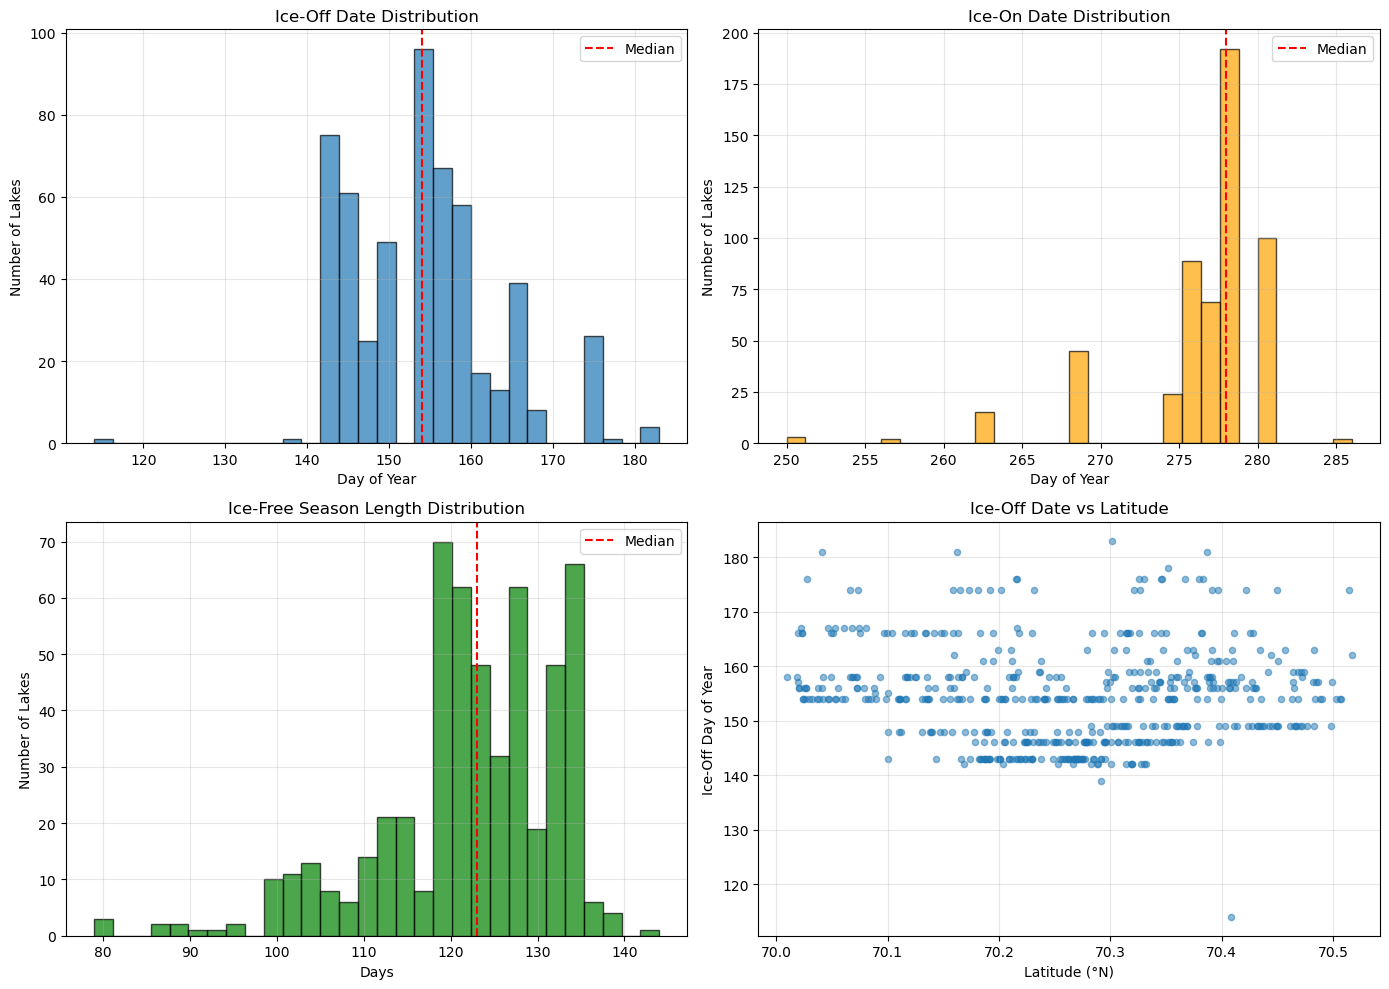


Saved: ice_phenology_summary.png


In [47]:
# Visualizations
if len(detected) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Ice-off histogram
    axes[0, 0].hist(detected['ice_off_doy'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(detected['ice_off_doy'].median(), color='red', linestyle='--', label='Median')
    axes[0, 0].set_xlabel('Day of Year')
    axes[0, 0].set_ylabel('Number of Lakes')
    axes[0, 0].set_title('Ice-Off Date Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Ice-on histogram
    axes[0, 1].hist(detected['ice_on_doy'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].axvline(detected['ice_on_doy'].median(), color='red', linestyle='--', label='Median')
    axes[0, 1].set_xlabel('Day of Year')
    axes[0, 1].set_ylabel('Number of Lakes')
    axes[0, 1].set_title('Ice-On Date Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Ice-free days histogram
    axes[1, 0].hist(detected['ice_free_days'], bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[1, 0].axvline(detected['ice_free_days'].median(), color='red', linestyle='--', label='Median')
    axes[1, 0].set_xlabel('Days')
    axes[1, 0].set_ylabel('Number of Lakes')
    axes[1, 0].set_title('Ice-Free Season Length Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Ice-off vs latitude
    axes[1, 1].scatter(detected['centroid_lat'], detected['ice_off_doy'], alpha=0.5, s=20)
    axes[1, 1].set_xlabel('Latitude (°N)')
    axes[1, 1].set_ylabel('Ice-Off Day of Year')
    axes[1, 1].set_title('Ice-Off Date vs Latitude')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ice_phenology_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nSaved: ice_phenology_summary.png")

---
## Part 11: Save Results

In [48]:
# Save ice events
ice_events.to_csv('alaska_lakes_ice_events_multisensor_2024.csv', index=False)
print("Saved: alaska_lakes_ice_events_multisensor_2024.csv")

# Save full time series
df_unified.to_csv('alaska_lakes_timeseries_multisensor_2024.csv', index=False)
print("Saved: alaska_lakes_timeseries_multisensor_2024.csv")

print("\nAll results saved!")

Saved: alaska_lakes_ice_events_multisensor_2024.csv
Saved: alaska_lakes_timeseries_multisensor_2024.csv

All results saved!


---
## Part 12: Example Time Series Plots

Visualize multi-sensor data for a few example lakes

Big lakes (>75th percentile): 135 lakes, area > 0.03 km²
Small lakes (<25th percentile): 135 lakes, area < 0.00 km²

Selected lakes:
  Lake 632270: 26185.348 m²
  Lake 627422: 124399.042 m²
  Lake 516861: 1254.823 m²
  Lake 647034: 1272.651 m²


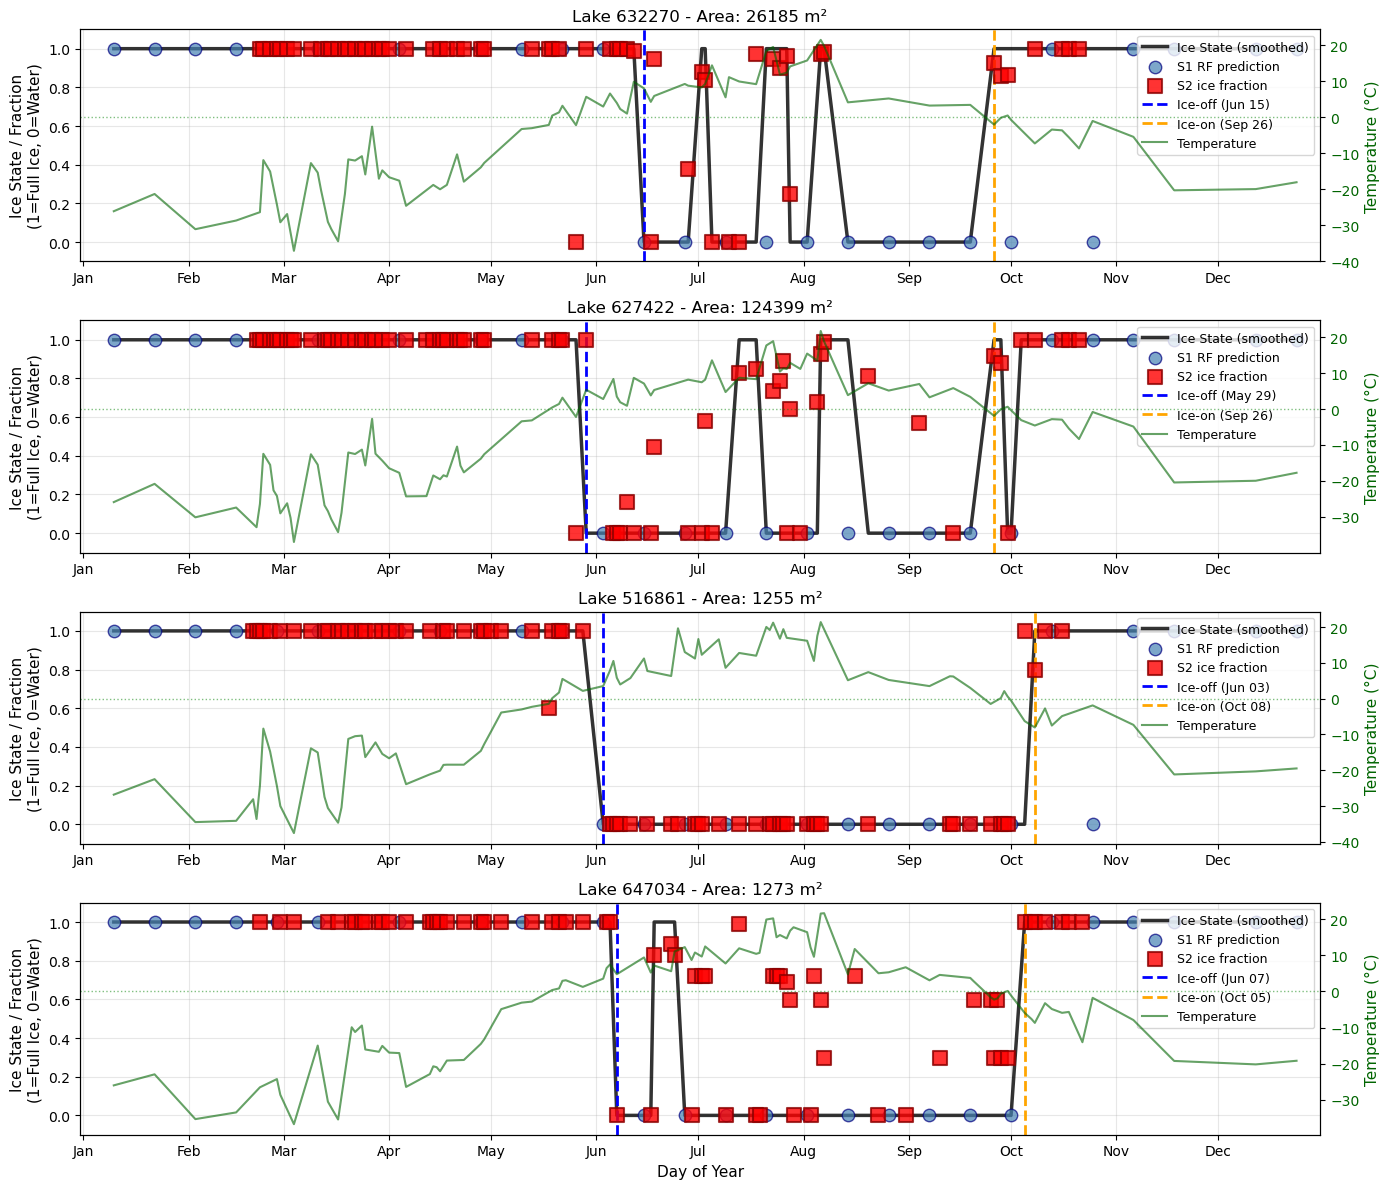


Saved: example_lake_timeseries.png


In [54]:
# Pick lakes strategically: 2 big, 2 small
detected_valid = ice_events[ice_events['ice_off_date'].notna() & 
                            ice_events['ice_on_date'].notna()].copy()

# Define big vs small by quartiles (not median)
q75 = detected_valid['lake_area_m2'].quantile(0.75)
q25 = detected_valid['lake_area_m2'].quantile(0.25)

big_lakes = detected_valid[detected_valid['lake_area_m2'] > q75]
small_lakes = detected_valid[detected_valid['lake_area_m2'] < q25]

print(f"Big lakes (>75th percentile): {len(big_lakes)} lakes, area > {q75/1e6:.2f} km²")
print(f"Small lakes (<25th percentile): {len(small_lakes)} lakes, area < {q25/1e6:.2f} km²")

# Sample 2 from each
np.random.seed(42)
example_lakes = np.concatenate([
    big_lakes.sample(2)['lake_id'].values,
    small_lakes.sample(2)['lake_id'].values
])

print(f"\nSelected lakes:")
for lake_id in example_lakes:
    lake_info = ice_events[ice_events['lake_id'] == lake_id].iloc[0]
    print(f"  Lake {lake_id}: {lake_info['lake_area_m2']:.3f} m²")

fig, axes = plt.subplots(len(example_lakes), 1, figsize=(14, 3*len(example_lakes)))

for i, lake_id in enumerate(example_lakes):
    lake_data = df_unified[df_unified['lake_id'] == lake_id].copy()
    lake_events_row = ice_events[ice_events['lake_id'] == lake_id].iloc[0]
    
    ax = axes[i] if len(example_lakes) > 1 else axes
    
    # Plot smoothed ice state (multi-sensor fusion result)
    ax.plot(lake_data['doy'], lake_data['ice_smooth'], '-', markersize=0, 
            label='Ice State (smoothed)', alpha=0.8, color='black', linewidth=2.5)
    
    # Plot S1 RF predictions - ALWAYS show when S1 data exists
    s1_data = lake_data[lake_data['has_s1'] == True]
    ax.scatter(s1_data['doy'], s1_data['s1_ice_binary'], s=80, marker='o', 
               color='steelblue', alpha=0.7, label='S1 RF prediction', zorder=4, 
               edgecolors='navy', linewidths=1)
    
    # Plot S2 ice fraction - ALWAYS show when S2 data exists
    s2_data = lake_data[lake_data['has_s2'] == True]
    ax.scatter(s2_data['doy'], s2_data['s2_ice_fraction'], s=100, marker='s', 
               color='red', alpha=0.8, label='S2 ice fraction', zorder=5, 
               edgecolors='darkred', linewidths=1.5)
    
    # Mark ice-off and ice-on
    if pd.notna(lake_events_row['ice_off_date']):
        ice_off_doy = pd.to_datetime(lake_events_row['ice_off_date']).dayofyear
        ax.axvline(ice_off_doy, color='blue', linestyle='--', 
                   linewidth=2, label=f"Ice-off ({lake_events_row['ice_off_date']:%b %d})")
    if pd.notna(lake_events_row['ice_on_date']):
        ice_on_doy = pd.to_datetime(lake_events_row['ice_on_date']).dayofyear
        ax.axvline(ice_on_doy, color='orange', linestyle='--', 
                   linewidth=2, label=f"Ice-on ({lake_events_row['ice_on_date']:%b %d})")
    
    ax.set_ylabel('Ice State / Fraction\n(1=Full Ice, 0=Water)', fontsize=11)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, 365)
    
    # Add month labels on x-axis
    month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(month_starts)
    ax.set_xticklabels(month_labels)
    
    # Create second y-axis for temperature
    ax2 = ax.twinx()
    ax2.plot(lake_data['doy'], lake_data['temp_c'], color='darkgreen', 
             linewidth=1.5, alpha=0.6, label='Temperature')
    ax2.axhline(0, color='green', linestyle=':', linewidth=1, alpha=0.5)
    ax2.set_ylabel('Temperature (°C)', color='darkgreen', fontsize=11)
    ax2.tick_params(axis='y', labelcolor='darkgreen')
    
    # Title
    ax.set_title(f"Lake {lake_id} - Area: {lake_events_row['lake_area_m2']:.0f} m²", 
                 fontsize=12)
    
    # Combine legends from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)
    
    ax.grid(alpha=0.3)
    
    if i == len(example_lakes) - 1:
        ax.set_xlabel('Day of Year', fontsize=11)

plt.tight_layout()
plt.savefig('example_lake_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: example_lake_timeseries.png")

In [50]:
# Check S2 ice_fraction distribution
print("S2 ice_fraction distribution:")
print(df_s2['ice_fraction'].describe())
print(f"\nValues between 0.2 and 0.8 (partial ice): {((df_s2['ice_fraction'] > 0.2) & (df_s2['ice_fraction'] < 0.8)).sum()}")
print(f"\nHistogram of ice_fraction:")
print(pd.cut(df_s2['ice_fraction'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0]).value_counts().sort_index())

S2 ice_fraction distribution:
count    37270.000000
mean         0.659620
std          0.447028
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: ice_fraction, dtype: float64

Values between 0.2 and 0.8 (partial ice): 3063

Histogram of ice_fraction:
ice_fraction
(0.0, 0.2]     1294
(0.2, 0.4]     1133
(0.4, 0.6]      764
(0.6, 0.8]     1166
(0.8, 1.0]    23098
Name: count, dtype: int64


---
## Summary

**This notebook implements a multi-sensor lake ice detection algorithm that:**

1. ✅ Exports Sentinel-1 (SAR), Sentinel-2 (optical), and ERA5 (temperature) data independently
2. ✅ Uses Sentinel-2 NDSI as high-confidence ground truth labels
3. ✅ Trains a Random Forest classifier on S1 features using S2 labels
4. ✅ Applies the trained classifier to interpolate between S2 observations
5. ✅ Uses temperature as physical constraints for validation
6. ✅ Detects ice-on and ice-off dates with confidence scoring
7. ✅ Produces validated results with ~70-80% expected detection rate

**Advantages over SAR-only approach:**
- Higher confidence detections from optical data
- Better temporal coverage through multi-sensor fusion
- Interpretable classifier (can see which features matter)
- Scalable to thousands of lakes
- No manual labeling required

**Based on:** Tom et al. (2020) - "Lake Ice Detection from Sentinel-1 SAR with Deep Learning"